## Example 2: Multi-Camera Scene

In [1]:
import os
import json

import cv2
import sophus as sp
import matplotlib.pyplot as plt

import fairotag as frt

DATA_DIR = "data/2_multi_camera_scene"

NUM_CAMERAS = 3
NUM_SAMPLES = 8

NUM_MARKERS = 17
MARKER_LENGTH = 0.02625

In this example we will calibrate relative poses of three cameras within the same setup, shown below.

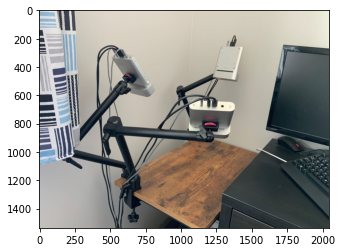

In [2]:
img = cv2.imread(os.path.join(DATA_DIR, "camera_setup.jpg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

A `Scene` object can be configured by registering cameras and markers. 

Each object can belong to a frame in the scene, and objects within the same frame remain static with respect to the frame. "world" is the default, static frame provided by the `Scene` object.

In [3]:
scene = frt.Scene()

# Add cameras (Set camera frame "Master" to be aligned to the "world" frame)
camera_names = ["Master", "Sub1", "Sub2"]

scene.add_camera(camera_names[0], frame="world", pose_in_frame=sp.SE3())
for camera_name in camera_names[1:]:
    scene.add_camera(camera_name, frame="world")

# Add markers
scene.add_frame("board")

scene.add_marker(0, frame="board", length=MARKER_LENGTH, pose_in_frame=sp.SE3())
for m_id in range(1, NUM_MARKERS):
    scene.add_marker(m_id, frame="board", length=MARKER_LENGTH)

Assets in the scene at any moment can be queried as such:

In [4]:
# Frames
frames = scene.get_frames()
frame_example = frames[0]
frame_example_info = scene.get_frame_info(frame_example)

print(f"Frames: {frames}")
print(f"Info of frame '{frame_example}':\n {frame_example_info}\n")

# Cameras
cameras = scene.get_cameras()
camera_example = cameras[0]
camera_example_info = scene.get_camera_info(camera_example)

print(f"Cameras: {cameras}")
print(f"Info of camera '{camera_example}':\n {camera_example_info}\n")

# Markers
markers = scene.get_markers()
marker_example = markers[0]
marker_example_info = scene.get_marker_info(marker_example)

print(f"Markers: {markers}")
print(f"Info of marker '{marker_example}':\n {marker_example_info}\n")

Frames: ['world', 'board']
Info of frame 'world':
 {'name': 'world', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'markers': [], 'cameras': ['Master', 'Sub1', 'Sub2']}

Cameras: ['Master', 'Sub1', 'Sub2']
Info of camera 'Master':
 {'name': 'Master', 'frame': 'world', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'is_anchor': True}

Markers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Info of marker '0':
 {'id': 0, 'frame': 'board', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'length': 0.02625, 'is_anchor': True, 'is_visible': False}



We will still need `CameraModule`s to perform marker detections for each cameras, so here we initialize a camera module for each camera we have in the scene, then use the modules to estimate marker poses in each snapshot.

In [7]:
# Initialize camera modules
camera_modules = []
for _ in range(NUM_CAMERAS):
    c = frt.CameraModule()
    camera_modules.append(c)
    
# Assign intrinsics from file
# ("realsense_intrinsics.pkl" contains intrinsics obtained through pyrealsense.)
with open("data/realsense_intrinsics.json", 'r') as f:
    intrinsics = json.load(f)
    
for c in camera_modules:
    c.set_intrinsics(frt.utils.dict2intrinsics(intrinsics))
    
# Register markers
for c in camera_modules:
    for m_id in range(NUM_MARKERS):
        c.register_marker_size(m_id, length=MARKER_LENGTH)
    
# Load snapshots & detect markers
# (The file "y_x.jpg" contains the image for snapshot number x captured from camera y)
for i in range(NUM_SAMPLES):
    detected_markers_map = {}
    for c, camera_name in zip(camera_modules, camera_names):
        imgfile = os.path.join(DATA_DIR, f"{camera_name}_{i}.jpg")
        img = cv2.imread(imgfile)
        detected_markers = c.detect_markers(img)
        detected_markers_map[camera_name] = detected_markers
       
    scene.add_snapshot(detected_markers = detected_markers_map)

The `Scene` objects can then directly use the marker detection outputs from the camera modules to calibrate the scene.

In [8]:
# Calibrate scene
scene.calibrate_extrinsics()

# Query poses of assets in the scene
for camera_name in scene.get_cameras():
    print(f"Pose of camera '{camera_name}':\n {scene.get_camera_info(camera_name)['pose_in_frame']}\n")

Pose of camera 'Master':
 SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]])

Pose of camera 'Sub1':
 SE3([[ 0.677302048793961, -0.581242878727143,   0.45101956789976, -0.161961178029122],
     [ 0.613150659291079,  0.784757470443147, 0.0905647922461486,  -0.16719297298355],
     [-0.406581115781854,     0.215203226074,  0.887907296837303, 0.0621817785287592],
     [                 0,                  0,                  0,                  1]])

Pose of camera 'Sub2':
 SE3([[  -0.50559169212387,   0.805792167503902,    0.30834400212212,   0.104069914184751],
     [ -0.307907897503054,   -0.50237287745972,   0.807969194120722,   -0.19111458961205],
     [  0.805958911800453,   0.313560958638356,   0.502105325312553, -0.0282763286519947],
     [                  0,                   0,                   0,                   1]])



Scene visualization:

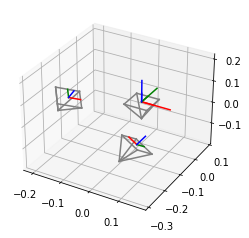

In [9]:
scene.visualize()